### Assignment 6
##### Name: Pranisaa Charnparttaravanit
##### ID: st121720

### Import Libraries

In [1]:
import csv
import math
import random
import pandas as pd
import numpy as np
from IPython.display import display, clear_output

### Load data

In [10]:
def split_data_set(df, training_ratio=0.6, shuffle=True):
    if shuffle :
        df = df.sample(frac=1)
    t_size = int(df.shape[0] * training_ratio)
    # train , test 
    return df.iloc[:t_size], df.iloc[t_size:]

class NaiveBay:
    def __init__(self, with_prior=True):
        self.x_mean = {}
        self.x_std = {}
        
        self.priors = {}
        self.y_class = []
        self.pred_with_prior = with_prior
    
    def fit(self, X, y):
        # X : 2d array 
        # y : 1d array
        
        self.priors = {} # reset priority 
        
        # reset saving parameters
        self.x_mean = {}
        self.x_std = {}
        
        # xy_df should be in format columns = [x0, x1, ..., xn, y]
        self.y_class = np.unique(y)
        
        for y_class in self.y_class : 
            y_index = np.where(y == y_class) # select X by class 
            
            # select X data of y_class answer
            y_X = X.copy()[y_index] # X.copy() => prevent update the original X variable.
            
            x_mean = y_X.mean(axis=0) # find mean of each column
            x_std = y_X.std(axis=0) # find the stdev of each column
            # save parameter values 
            self.x_mean[y_class] = x_mean
            self.x_std[y_class] = x_std
            
            self.priors[y_class] = 1
            if self.pred_with_prior : 
                self.priors[y_class] *=  (y_X.shape[0]/ X.shape[0])                 
                
    def calculate_probability(self, x, mean, stdev):
        '''
        Equation from 
        https://en.wikipedia.org/wiki/Naive_Bayes_classifier#:~:text=A%20class's%20prior%20may%20be,total%20number%20of%20samples%3E).
        '''
        top = np.exp(-1 * np.power((x-mean), 2) / (2*np.power(stdev,2)))
        bot = np.sqrt(2*np.pi*np.power(stdev,2))
        p = top/bot
        return p 
    
    def predict(self, X):
        
        # save prob for each class 
        pred_df = pd.DataFrame()
        
        for y_class in self.y_class : 
            
            prior_y = self.priors[y_class]
            
            # a vector of mean 
            y_params_mean = self.x_mean[y_class]
            # a vector of variance 
            y_params_std = self.x_std[y_class]
            
            # probability of y given X 
            yp_by_features = self.calculate_probability(X, y_params_mean, y_params_std)
            yp_by_features =  yp_by_features * (prior_y ** prior_y)         
            yp = np.prod(yp_by_features, axis=1)
            pred_df[y_class] = yp
    
        pred_df['y_pred'] = np.argmax(pred_df.values, axis=1)
        pred_df['y_pred'] = [pred_df.columns[v] for v in pred_df['y_pred']]
        self.pred_df = pred_df
        return pred_df['y_pred'].values

In [11]:
def get_accuracy(y_pred, y_true):
    return (y_pred == y_true).sum() / len(y_true)

In [12]:
df = pd.read_csv('diabetes.csv')
# df.Outcome.hist()
training_set, test_set = split_data_set(df, 0.8)

outcome_ratio = (training_set.Outcome.value_counts() / len(training_set)).to_dict()

print('Outcome Proportion')
print(outcome_ratio)

print('Can we conclude p(y=1) == p(y=0) ? ')
print('The answer is', outcome_ratio[0] == outcome_ratio[1])

X_train, y_train = training_set.drop(columns='Outcome').values, training_set['Outcome'].values
X_test, y_test = test_set.drop(columns='Outcome').values, test_set['Outcome'].values

nb= NaiveBay(with_prior=False)
print('='*30)
print('Model without prior')
nb.fit(X_train, y_train)
train_pred = nb.predict(X_train)
test_pred = nb.predict(X_test)
print('Train Accuracy :', get_accuracy(train_pred, y_train))
print('Test Accuracy : ', get_accuracy(test_pred, y_test))
print('='*30)

print('Model with prior')
nb = NaiveBay(with_prior=True)
nb.fit(X_train, y_train)
print(nb.priors)
my_pred = nb.predict(X_test)
train_pred = nb.predict(X_train)
test_pred = nb.predict(X_test)
print('Train Accuracy :', get_accuracy(train_pred, y_train))
print('Test Accuracy : ', get_accuracy(test_pred, y_test))

Outcome Proportion
{0: 0.6449511400651465, 1: 0.3550488599348534}
Can we conclude p(y=1) == p(y=0) ? 
The answer is False
Model without prior
Train Accuracy : 0.750814332247557
Test Accuracy :  0.6948051948051948
Model with prior
{0: 0.6449511400651465, 1: 0.3550488599348534}
Train Accuracy : 0.7687296416938111
Test Accuracy :  0.7207792207792207


In [13]:
# Generate text data for two classes, "statement" and "question"

text_train = [['This is my novel book', 'statement'],
              ['this book has more than one author', 'statement'],
              ['is this my book', 'question'],
              ['They are novels', 'statement'],
              ['have you read this book', 'question'],
              ['who is the novels author', 'question'],
              ['what are the characters', 'question'],
              ['This is how I bought the book', 'statement'],
              ['I like fictional characters', 'statement'],
              ['what is your favorite book', 'question']]

text_test = [['this is the book', 'statement'], 
             ['who are the novels characters', 'question'], 
             ['is this the author', 'question']]

# Load training and test data into pandas data frames

training_data = pd.DataFrame(text_train, columns= ['sentence', 'class'])
testing_data = pd.DataFrame(text_test, columns= ['sentence', 'class'])


In [14]:
# Partition training data by class

# stmt_docs = [train['sentence'] for index,train in training_data.iterrows() if train['class'] == 'statement']
# question_docs = [train['sentence'] for index,train in training_data.iterrows() if train['class'] == 'question']

stmt_docs = training_data[training_data['class'].str.contains('statement')]['sentence'].values
question_docs = training_data[training_data['class'].str.contains('question')]['sentence'].values

# Get word frequencies for each sentence and class
def get_words(text):
    # Initialize word list
    words = [];
    # Loop through each sentence in input array
    for text_row in text:       
        # Check the number of words. Assume each word is separated by a blank space
        # so that the number of words is the number of blank spaces + 1
        number_of_spaces = text_row.count(' ')
        # loop through the sentence and get words between blank spaces.
        for i in range(number_of_spaces):
            # Check for for last word
            words.append([text_row[:text_row.index(' ')].lower()])
            text_row = text_row[text_row.index(' ')+1:]  
            i = i + 1        
        words.append([text_row])
    return np.unique(words)

# Get frequency of each word in each document

def get_doc_word_frequency(words, text):  
    word_freq_table = np.zeros((len(text),len(words)), dtype=int)
    i = 0
    for text_row in text:
        # Insert extra space between each pair of words to prevent
        # partial match of words
        text_row_temp = ''
        for idx, val in enumerate(text_row):
            if val == ' ':
                 text_row_temp = text_row_temp + '  '
            else:
                  text_row_temp = text_row_temp + val.lower()
        text_row = ' ' + text_row_temp + ' '
        j = 0
        for word in words: 
            word = ' ' + word + ' '
            freq = text_row.count(word)
            word_freq_table[i,j] = freq
            j = j + 1
        i = i + 1
        
    return word_freq_table

In [15]:
# Get word frequencies for statement documents
word_list_s = get_words(stmt_docs)
word_freq_table_s = get_doc_word_frequency(word_list_s, stmt_docs)
tdm_s = pd.DataFrame(word_freq_table_s, columns=word_list_s)
print(tdm_s)

   are  author  book  bought  characters  fictional  has  how  i  is  like  \
0    0       0     1       0           0          0    0    0  0   1     0   
1    0       1     1       0           0          0    1    0  0   0     0   
2    1       0     0       0           0          0    0    0  0   0     0   
3    0       0     1       1           0          0    0    1  1   1     0   
4    0       0     0       0           1          1    0    0  1   0     1   

   more  my  novel  novels  one  than  the  they  this  
0     0   1      1       0    0     0    0     0     1  
1     1   0      0       0    1     1    0     0     1  
2     0   0      0       1    0     0    0     1     0  
3     0   0      0       0    0     0    1     0     1  
4     0   0      0       0    0     0    0     0     0  


In [16]:
# Get word frequencies over all statement documents
freq_list_s = word_freq_table_s.sum(axis=0) 
freq_s = dict(zip(word_list_s,freq_list_s))
print(freq_s)

{'are': 1, 'author': 1, 'book': 3, 'bought': 1, 'characters': 1, 'fictional': 1, 'has': 1, 'how': 1, 'i': 2, 'is': 2, 'like': 1, 'more': 1, 'my': 1, 'novel': 1, 'novels': 1, 'one': 1, 'than': 1, 'the': 1, 'they': 1, 'this': 3}


In [17]:
# Get word frequencies for question documents
word_list_q = get_words(question_docs)
word_freq_table_q = get_doc_word_frequency(word_list_q, question_docs)
tdm_q = pd.DataFrame(word_freq_table_q, columns=word_list_q)
print(tdm_q)

   are  author  book  characters  favorite  have  is  my  novels  read  the  \
0    0       0     1           0         0     0   1   1       0     0    0   
1    0       0     1           0         0     1   0   0       0     1    0   
2    0       1     0           0         0     0   1   0       1     0    1   
3    1       0     0           1         0     0   0   0       0     0    1   
4    0       0     1           0         1     0   1   0       0     0    0   

   this  what  who  you  your  
0     1     0    0    0     0  
1     1     0    0    1     0  
2     0     0    1    0     0  
3     0     1    0    0     0  
4     0     1    0    0     1  


In [18]:
# Get word frequencies over all question documents
freq_list_q = word_freq_table_q.sum(axis=0) 
freq_q = dict(zip(word_list_q,freq_list_q))
print(freq_q)

{'are': 1, 'author': 1, 'book': 3, 'characters': 1, 'favorite': 1, 'have': 1, 'is': 3, 'my': 1, 'novels': 1, 'read': 1, 'the': 2, 'this': 2, 'what': 2, 'who': 1, 'you': 1, 'your': 1}


In [19]:
# Get word probabilities for statement class
prob_s = []
for word, count in zip(word_list_s, freq_list_s):
    #print(word, count)
    prob_s.append(count/len(word_list_s))
    
# Get word probabilities for question class

prob_q = []
for count in freq_list_q:
    prob_q.append(count/len(word_list_q))
    
print('Probability of words for "statement" class \n')
print(dict(zip(word_list_s, prob_s)))
print('------------------------------------------- \n')
print('Probability of words for "question" class \n')
print(dict(zip(word_list_q, prob_q)))


Probability of words for "statement" class 

{'are': 0.05, 'author': 0.05, 'book': 0.15, 'bought': 0.05, 'characters': 0.05, 'fictional': 0.05, 'has': 0.05, 'how': 0.05, 'i': 0.1, 'is': 0.1, 'like': 0.05, 'more': 0.05, 'my': 0.05, 'novel': 0.05, 'novels': 0.05, 'one': 0.05, 'than': 0.05, 'the': 0.05, 'they': 0.05, 'this': 0.15}
------------------------------------------- 

Probability of words for "question" class 

{'are': 0.0625, 'author': 0.0625, 'book': 0.1875, 'characters': 0.0625, 'favorite': 0.0625, 'have': 0.0625, 'is': 0.1875, 'my': 0.0625, 'novels': 0.0625, 'read': 0.0625, 'the': 0.125, 'this': 0.125, 'what': 0.125, 'who': 0.0625, 'you': 0.0625, 'your': 0.0625}


In [20]:
# Calculate prior for one class
def prior(className):    
    denominator = len(stmt_docs) + len(question_docs)
    
    if className == 'statement':
        numerator =  len(stmt_docs)
    else:
        numerator =  len(question_docs)
    return np.divide(numerator,denominator)

# Calculate class conditional probability for a sentence
def classCondProb(sentence, className):
    words = get_words(sentence)
    prob = 1
    found_word = False 
    
    # fixing the error from in-lab exercise 
    for word in words:
        if className == 'statement':
            if word in word_list_s :   
                idx = np.where(word_list_s == word)
                prob = prob * prob_s[np.array(idx)[0,0]]
                # check that there is a word in training set
                found_word = True
        else:
            if word in word_list_q :   
                idx = np.where(word_list_q == word)
                prob = prob * prob_q[np.array(idx)[0,0]]
                # check that there is a word in training set
                found_word = True
    if found_word :
        prob = 0
    return prob

# Predict class of a sentence
def predict(sentence):
    prob_statement = classCondProb(sentence, 'statement') * prior('statement')
    prob_question = classCondProb(sentence, 'question') * prior('question')
    if  prob_statement > prob_question:
        return 'statement'
    else:
        return 'question'

In [21]:
test_docs = list([test['sentence'] for index,test in testing_data.iterrows()])
print('Getting prediction for %s"' % test_docs[0])
predict(test_docs[0])

Getting prediction for this is the book"


'question'

In [22]:
class TextNaiveBay:
    def __init__(self, with_prior=False):
        self.word_freqs = {} 
        self.n_words = {}
        self.y_class = {}
        self.with_prior = with_prior
        
    def get_word_frequency(self, sentence_array):
        # make text_array into 1d array 
        sentence_series = pd.Series(sentence_array)
        sentence_series += ' ' # add space for spliting words
        word_series = pd.Series(sentence_series.sum().split(' '))
        word_series = word_series[word_series != ' '] # drop unwanted elements
        
        # return dict of counting word frequency 
        # <key> word : <value> frequency 
        return word_series.value_counts().to_dict(), len(word_series)
        
    def fit(self, X, y):
        # X => array of vector
        # y => array of class
        self.y_class = pd.Series(y).value_counts().to_dict()
        for y_class in self.y_class : 
            y_index = np.where(y == y_class)
            
            y_X = X.copy()[y_index]
            self.word_freqs[y_class], self.n_words[y_class] = self.get_word_frequency(y_X)
            
        all_X = X.copy()
        self.word_freqs['all'], self.n_words['all'] = self.get_word_frequency(all_X)
        self.y_class['all'] = X.shape[0] # count the number of samples
        
    def predict(self, X, alpha=1):
        '''
        Laplace Smoothing Doc ! 
        
        https://medium.com/syncedreview/applying-multinomial-naive-bayes-to-nlp-problems-a-practical-explanation-4f5271768ebf#:~:text=A%20solution%20would%20be%20Laplace,incorporated%20in%20every%20probability%20estimate.&text=this%20is%20a%20way%20of,it%20is%20called%20Laplace%20smoothing.
        
        with laplace smoothing
        alpha is a laplace smoothing parameter. when alpha > 0 means using laplace transform. 
        if alpha == 0 : disable laplace smoothing : 
            == > if a class doesn't have an input word, the probability of that class will be 0.
        '''
        d = len(self.word_freqs['all']) # the number of possible words in all categories
        pred_df = pd.DataFrame()
        
        # p(y|x) = TT p(x|y)
        
        n = self.y_class['all'] # number of training size
        for y_class in self.y_class :
            if y_class != 'all' : 
                y_hat = []
                n_y = self.y_class[y_class] # the number of class y in training set 
                n_wy = self.n_words[y_class] # the number of words occur in y_class 
                for sentence in X : 
                    p_xy = 1
                    words = pd.Series(sentence.split(' '))                
                    for w in words : 
                        n_xy = 0
                        if w in self.word_freqs[y_class] : 
                            n_xy = self.word_freqs[y_class][w] # the number of word x happens in class y   

                        # p(x|y) = n(x, y=yi) / n(yi)
                        p_xy *= (n_xy + alpha) / (n_wy + alpha*d) 

                    if self.with_prior :
                        p_xy *= n_y / n
#                     clear_output(wait=True)
#                     display(sentence)
#                     display(f'class : {y_class} ; prob : {p_xy}')
                    y_hat.append(p_xy)               
                pred_df[y_class] = y_hat
    
        pred_df['y_pred'] = np.argmax(pred_df.values, axis=1)
        pred_df['y_pred'] = [pred_df.columns[v] for v in pred_df['y_pred']]
        self.pred_df = pred_df
        return pred_df['y_pred'].values

In [23]:
nb_text = TextNaiveBay(with_prior=True)
nb_text.fit(training_data['sentence'].values, training_data['class'])
train_pred = nb_text.predict(training_data['sentence'].values)
test_pred = nb_text.predict(testing_data['sentence'].values)

print("Result of Laplace smoothing ...")
print('Training set accuracy', get_accuracy(train_pred, training_data['class'].values))
print('Test set accuracy', get_accuracy(test_pred, testing_data['class'].values))

Result of Laplace smoothing ...
Training set accuracy 1.0
Test set accuracy 0.6666666666666666


In [26]:
df = pd.read_csv('Musical_instruments_reviews.csv')
df.tail()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
10256,A14B2YH83ZXMPP,B00JBIVXGC,Lonnie M. Adams,"[0, 0]","Great, just as expected. Thank to all.",5.0,Five Stars,1405814400,"07 20, 2014"
10257,A1RPTVW5VEOSI,B00JBIVXGC,Michael J. Edelman,"[0, 0]",I've been thinking about trying the Nanoweb st...,5.0,"Long life, and for some players, a good econom...",1404259200,"07 2, 2014"
10258,AWCJ12KBO5VII,B00JBIVXGC,Michael L. Knapp,"[0, 0]",I have tried coated strings in the past ( incl...,4.0,Good for coated.,1405987200,"07 22, 2014"
10259,A2Z7S8B5U4PAKJ,B00JBIVXGC,"Rick Langdon ""Scriptor""","[0, 0]","Well, MADE by Elixir and DEVELOPED with Taylor...",4.0,Taylor Made,1404172800,"07 1, 2014"
10260,A2WA8TDCTGUADI,B00JBIVXGC,TheTerrorBeyond,"[0, 0]","These strings are really quite good, but I wou...",4.0,"These strings are really quite good, but I wou...",1405468800,"07 16, 2014"


In [27]:
df["Text"] = df['reviewText'].fillna('')
df = df[df['Text'] != ' ']

In [29]:
df['Text'] = df['Text'].str.replace('[^a-zA-Z0-9 \n\.]|\.', '')
df['Text'] = df['Text'].str.lower()
df = df[['Text', 'overall']]
th_training_data , th_test_data = split_data_set(df, 0.7)

In [30]:
nb_text_take_home = TextNaiveBay(with_prior=True)
nb_text.fit(th_training_data['Text'].values, th_training_data['overall'].values)
th_train_pred = nb_text.predict(th_training_data['Text'].values)
th_test_pred = nb_text.predict(th_test_data['Text'].values)

In [31]:
print("Take Home Accuracy ")
print('Training set accuracy', get_accuracy(th_train_pred, th_training_data['overall'].values))
print('Test set accuracy', get_accuracy(th_test_pred, th_test_data['overall'].values))

Take Home Accuracy 
Training set accuracy 0.7257031467557783
Test set accuracy 0.6768431308866515


In [33]:
from sklearn.metrics import confusion_matrix
labels = df['overall'].sort_values().unique()
kwargs = dict(labels=labels,normalize='true')
c_mat_train = confusion_matrix(th_train_pred, th_training_data['overall'].values, **kwargs)
c_mat_test = confusion_matrix(th_test_pred, th_test_data['overall'].values, **kwargs)

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

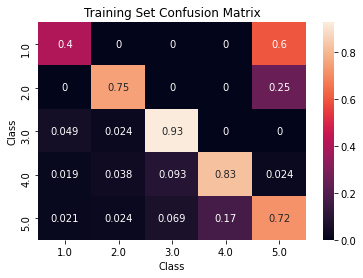

In [35]:
kwargs = dict(xticklabels=labels, yticklabels=labels, annot=True)
ax = sns.heatmap(c_mat_train, **kwargs)
ax.set(title="Training Set Confusion Matrix",
      xlabel="Class",
      ylabel="Class",)
plt.show()

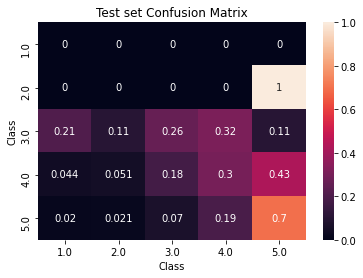

In [36]:
kwargs = dict(xticklabels=labels, yticklabels=labels, annot=True)
ax = sns.heatmap(c_mat_test, **kwargs)
ax.set(title="Test set Confusion Matrix",
      xlabel="Class",
      ylabel="Class",)
plt.show()